In [ ]:
############### split dataset into train and val
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
#Step 0: Define source folders
# -----------------------------
image_folder = "/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/2d_images"
mask_folder = "/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/2d_masks"

# -----------------------------
# Step 1: Create train/val folders
# -----------------------------
base_dir = "/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset"
train_image_dir = os.path.join(base_dir, "train/images")
train_mask_dir = os.path.join(base_dir, "train/masks")
val_image_dir = os.path.join(base_dir, "val/images")
val_mask_dir = os.path.join(base_dir, "val/masks")

for folder in [train_image_dir, train_mask_dir, val_image_dir, val_mask_dir]:
    os.makedirs(folder, exist_ok=True)

# -----------------------------
# Step 2: Match images and masks
# -----------------------------
all_images = [f for f in os.listdir(image_folder) if f.endswith(".png")]
all_masks = [f for f in os.listdir(mask_folder) if f.endswith(".png")]

image_prefix_to_mask = {f.split(".png")[0]: f for f in all_masks}
matched_images, matched_masks = [], []

for img_file in all_images:
    prefix = img_file.split(".png")[0]
    if prefix in image_prefix_to_mask:
        matched_images.append(img_file)
        matched_masks.append(image_prefix_to_mask[prefix])

# -----------------------------
# Step 3: Split into train/val
# -----------------------------
train_images, val_images, train_masks, val_masks = train_test_split(
    matched_images, matched_masks, test_size=0.2, random_state=42
)

# -----------------------------
# Step 4: Copy files
# -----------------------------
for src_img, src_mask in zip(train_images, train_masks):
    shutil.copy(os.path.join(image_folder, src_img), train_image_dir)
    shutil.copy(os.path.join(mask_folder, src_mask), train_mask_dir)

for src_img, src_mask in zip(val_images, val_masks):
    shutil.copy(os.path.join(image_folder, src_img), val_image_dir)
    shutil.copy(os.path.join(mask_folder, src_mask), val_mask_dir)

print(f"Train: {len(train_images)} images, Val: {len(val_images)} images")

Train: 6554 images, Val: 1639 images


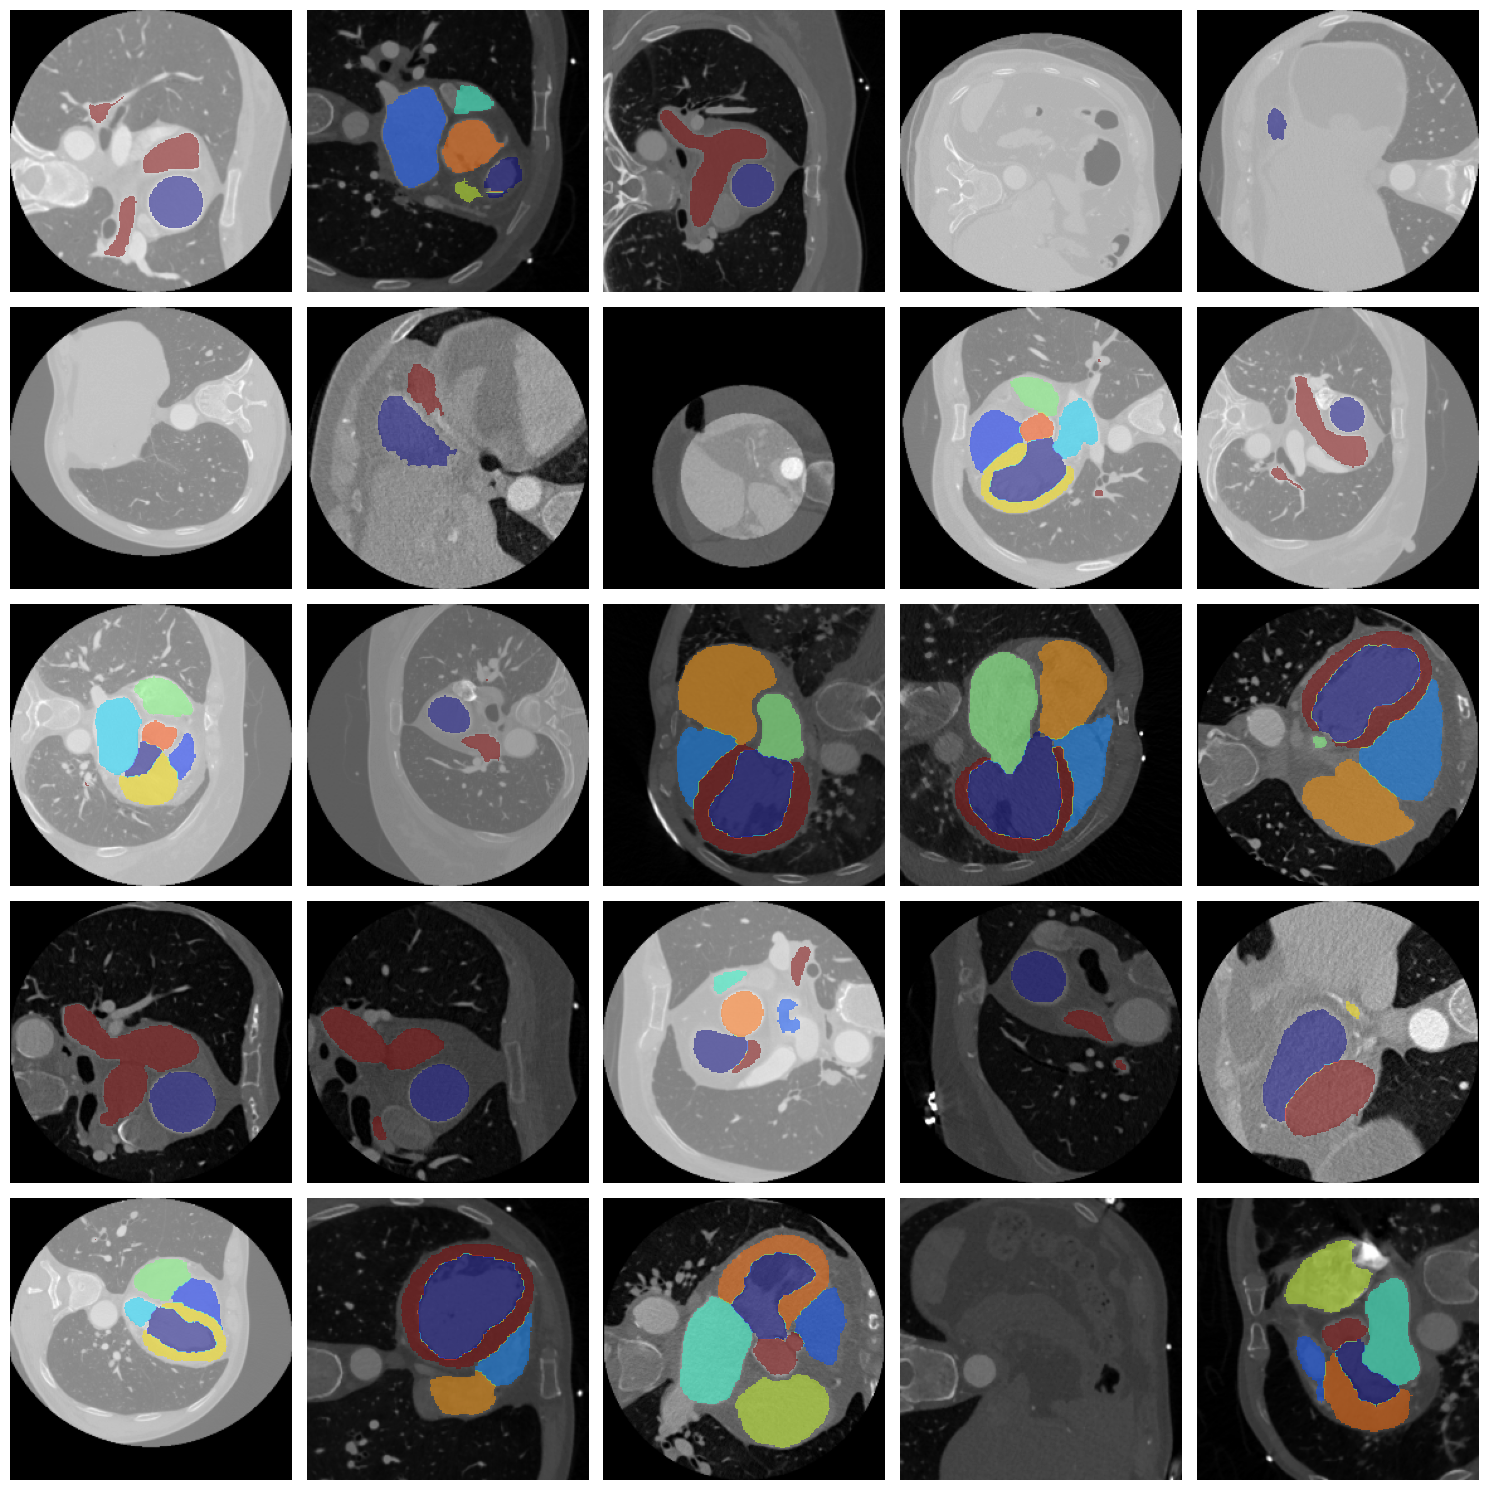

In [ ]:
##### whs CT 2D DataLoader ##########################
import os
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2


# -----------------------------
# Create dataset class
# -----------------------------
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, trans=None, num_classes=8):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.trans = trans
        self.num_classes = num_classes
        self.path_image = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")]
        self.path_mask = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")]

    def __getitem__(self, idx):
        image = np.array(Image.open(self.path_image[idx]))
        mask = cv2.imread(self.path_mask[idx], 0)  # grayscale mask

        if self.trans:
            augmented = self.trans(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        img_t = torch.from_numpy(image).float().unsqueeze(0)
        mask_t = torch.nn.functional.one_hot(torch.from_numpy(mask).long(), self.num_classes).permute(2,0,1).float()

        return img_t, mask_t

    def __len__(self):
        return len(self.path_image)

# -----------------------------
# Define augmentations
# -----------------------------
transform_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

transform_val = A.Compose([
    A.Resize(224, 224)
])


train_image_dir='/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/train/images'
train_mask_dir='/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/train/masks'
val_image_dir='/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/val/images'
val_mask_dir='/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/val/masks'

# -----------------------------
# Load Dataset and DataLoader
# -----------------------------
train_dataset = Segmentation_Dataset(train_image_dir, train_mask_dir, trans=transform_train)
val_dataset = Segmentation_Dataset(val_image_dir, val_mask_dir, trans=transform_val)

train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=25, shuffle=False)

# -----------------------------
# Visualize one batch
# -----------------------------
imgs, masks = next(iter(train_loader))
batch_size = imgs.shape[0]
num_classes = masks.shape[1]

rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
for i in range(rows):
    for j in range(cols):
        idx = i*cols + j
        if idx >= batch_size:
            break
        ax = axes[i, j]
        img = imgs[idx][0].numpy()
        mask = torch.argmax(masks[idx], dim=0).numpy()
        ax.imshow(img, cmap="gray")
        mask_display = np.ma.masked_where(mask == 0, mask)
        ax.imshow(mask_display, alpha=0.5, cmap="jet")
        ax.axis('off')
plt.tight_layout()
plt.show()
